In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "/content/drive/MyDrive/Colab Notebooks/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

img_size = (224, 224)  # Kích thước phù hợp với EfficientNetB0
num_classes = 2  # Số lớp nhãn
# Check if the dataset is balanced
def get_class_counts(base_dir):
    counts = {}
    for dir in os.listdir(base_dir):
        counts[dir] = len(os.listdir(os.path.join(base_dir, dir)))
    return counts

class_counts = get_class_counts(train_dir)
print("Class counts:", class_counts)

# Data augmentation and preprocessing functions
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal")
])

def augment_and_preprocess(image, label): # Chỉ apply cho tập train
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

def preprocess_only(image, label):        # Chỉ apply cho tập test
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


# Data loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=img_size,
    shuffle=True, # Bật xáo trộn
    seed=123,
    color_mode="rgb"  # Mode color RGB (X-ray chỉ là ảnh đen trắng)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=img_size,
    seed=123,
    color_mode="rgb"
)
# Caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Áp dụng map cho dữ liệu
train_ds_aug = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds_pre  = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)


Class counts: {'NORMAL': 1349, 'PNEUMONIA': 3883}
Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
  # Model building
  def build_efficientnetb0_model(activation="sigmoid", learning_rate=1e-3):
      base_model = EfficientNetB0(
          include_top=False,
          weights="imagenet",
          input_shape=(img_size[0], img_size[1], 3)
      )
      base_model.trainable = False
      x = base_model.output

      # Global AveragePooling2D layer
      x = layers.GlobalAveragePooling2D()(x)
      x = layers.BatchNormalization()(x)
      x = layers.Dropout(0.5)(x)
      outputs = layers.Dense(1, activation="sigmoid")(x)
      loss = "binary_crossentropy"

      model = models.Model(inputs=base_model.input, outputs=outputs)
      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss=loss,
          metrics=["accuracy"]
      )
      return model, base_model


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Đánh giá bằng val_loss
    patience=5, # Dừng nếu 5 epochs liên tiếp không cải thiện
    mode='min',
    restore_best_weights=True, # Trả về weight của epoch train tốt nhất
    verbose=1
)
def train_and_evaluate(model, train_data, test_data, epochs=20):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=[early_stopping ]
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    # Compute evaluation metrics
    y_true = []
    y_pred = []

    for images, labels in test_data:
          preds = model.predict(images)
          preds = (preds > 0.5).astype(int)
          y_true.extend(labels.numpy().flatten())
          y_pred.extend(preds.flatten())

    # Confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    report = classification_report(y_true, y_pred)
    print(report)

    return history

Training EfficientNetB0 with sigmoid activation and class imbalance handling...
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 106s 513ms/step - accuracy: 0.7112 - loss: 0.6227 - val_accuracy: 0.6747 - val_loss: 0.5753
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 378ms/step - accuracy: 0.8676 - loss: 0.3094 - val_accuracy: 0.8013 - val_loss: 0.4180
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 84s 392ms/step - accuracy: 0.8815 - loss: 0.2807 - val_accuracy: 0.8381 - val_loss: 0.3588
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 377ms/step - accuracy: 0.8877 - loss: 0.2659 - val_accuracy: 0.8798 - val_loss: 0.2795
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 462ms/step - accuracy: 0.8989 - loss: 0.2476 - val_accuracy: 0.9103 - val_loss: 0.2250
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 72s 399ms/step - accuracy: 0.8901 - loss: 0.2492 - val_accuracy: 0.9022 - val_loss: 0.2282
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.8967 - loss: 0.2474 - val_accuracy: 0.8958 - val_loss: 0.2391
Ep

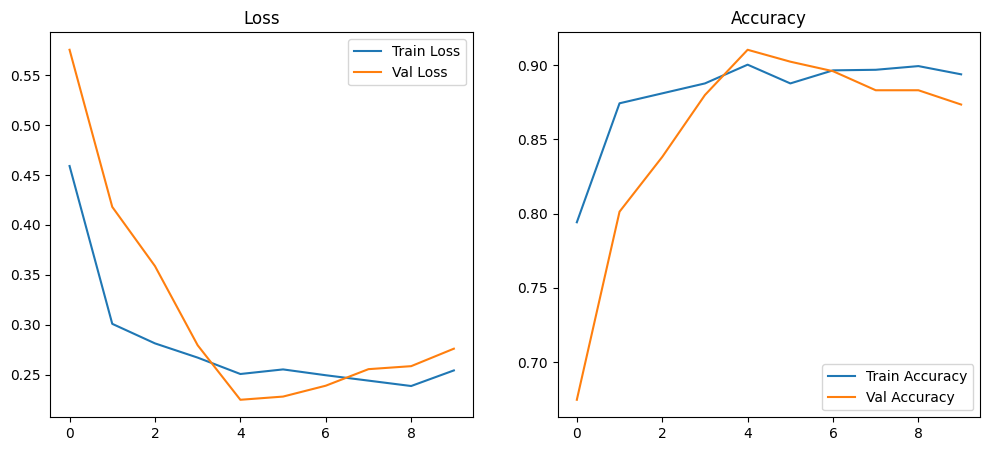

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Confusion Matrix:
[[204  30]
 [ 26 364]]


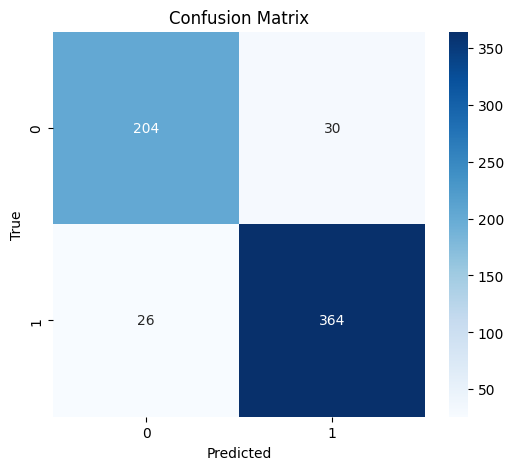


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       234
         1.0       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
# Train the model
model_b0_sigmoid_lr_low, base_model = build_efficientnetb0_model(activation="sigmoid", learning_rate=1e-3)
print("Training EfficientNetB0 with sigmoid activation and class imbalance handling...")
history_b0_sigmoid_lr_low = train_and_evaluate(model_b0_sigmoid_lr_low, train_ds_aug, test_ds_pre, epochs=15)

In [ ]:
base_model.trainable = True
# Xác định số tầng để unfreeze
fine_tune_at = int(len(base_model.layers) * 0.8)

# Đóng băng lại tất cả các lớp trước fine_tune_at, mở khóa phần còn lại
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Compile lại mô hình với learning rate nhỏ hơn
model_b0_sigmoid_lr_low.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
# Fine-Tuning
history_finetune = model_b0_sigmoid_lr_low.fit(
    train_ds_aug,
    epochs=30,  # Tiếp tục huấn luyện
    callbacks=[early_stopping, lr_scheduler],
    validation_data=test_ds_pre,
    initial_epoch=5  # Tiếp tục từ epoch 5

)


Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 138s 580ms/step - accuracy: 0.9500 - loss: 0.1177 - val_accuracy: 0.9167 - val_loss: 0.2146 - learning_rate: 1.0000e-05
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 69s 420ms/step - accuracy: 0.9529 - loss: 0.1154 - val_accuracy: 0.9167 - val_loss: 0.2148 - learning_rate: 1.0000e-05
Epoch 8/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 85s 441ms/step - accuracy: 0.9539 - loss: 0.1283 - val_accuracy: 0.9263 - val_loss: 0.1958 - learning_rate: 1.0000e-05
Epoch 9/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 80s 431ms/step - accuracy: 0.9580 - loss: 0.1158 - val_accuracy: 0.9183 - val_loss: 0.2089 - learning_rate: 1.0000e-05
Epoch 10/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.9572 - loss: 0.1098 - val_accuracy: 0.9199 - val_loss: 0.2071 - learning_rate: 1.0000e-05
Epoch 11/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 424ms/step - accuracy: 0.9552 - loss: 0.1151 - val_accuracy: 0.9199 - val_loss: 0.1971 - learning_rate: 1.0000e-05
Epoch 12/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 87

In [ ]:
# prompt: save model .keras về drive cho best_model sau khi dừng fine-tune và restore model weights từ best epoch 8.

# Save the best model weights to your Google Drive
model_save_path = "/content/drive/MyDrive/Colab Notebooks/best_model.keras"
model_b0_sigmoid_lr_low.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Restore the weights from the best epoch (if early stopping restored them)
# This part is redundant if restore_best_weights=True in early_stopping
# model_b0_sigmoid_lr_low.load_weights(model_save_path)
# print("Model weights restored from the best epoch.")


Model saved to: /content/drive/MyDrive/Colab Notebooks/best_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


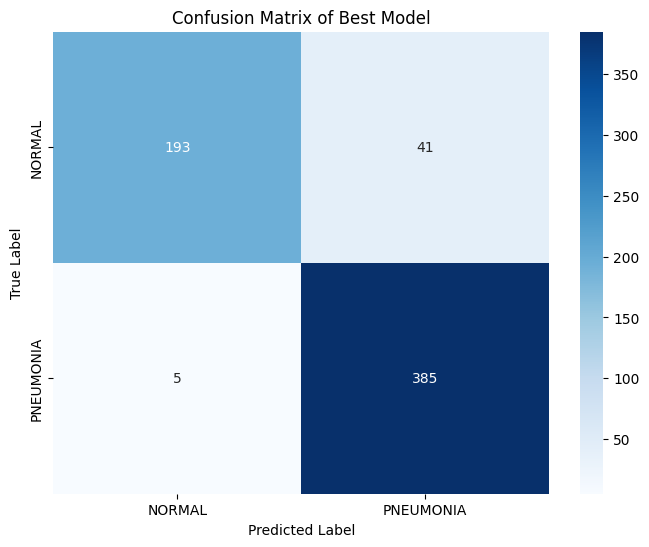

In [ ]:
# prompt: vẽ ma trận nhầm lẫn của best model

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model_save_path = "/content/drive/MyDrive/Colab Notebooks/best_model.keras"
loaded_model = tf.keras.models.load_model(model_save_path)

# Assuming you have your test data in test_ds_pre
y_true = []
y_pred = []

for images, labels in test_ds_pre:
    preds = loaded_model.predict(images)
    if loaded_model.output_shape[-1] == 1:  # sigmoid
        preds = (preds > 0.5).astype(int)
    else:  # softmax
        preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend(preds.flatten())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Best Model")
plt.show()
